## 3) Projeto de controle NL
O projeto de controle da planta pelo método da linearização por realimentação pretende simplificar a planta por um sistema linear equivalente.

O sistema anterior pode ser descrito da seguinte forma:

$$
\ddot y + \underbrace{(0.5 - y^2)\dot y}_{f(y, \dot y)} + 4y = v\\
v = \hat f(y,\dot y) + w(t) - a_1 \dot y - a_0 y \\
w(t) = K\int e(t) dt
$$

De forma com que $\hat f(y,\dot y)\approx f(y,\dot y)$. E o sistema não linear seja aproximado para:

$$
\ddot y + \underbrace{f(y,\dot y) - \hat f(y,\dot y)}_{\sim\ 0} + 4y + a_1 \dot y + a_0 y = w 
$$

De forma a obter a seguinte função de transferência equivalente da planta:

$$
\frac{Y(s)}{W(s)} = \frac{1}{s^2+ a_1 s + (4 + a_0)}
$$

Como é desejado que o sistema não tenha _over-shoot_, o sistema deve ser pelo menos críticamente amortecido.

$$
\frac{1}{s^2+ a_1 s + (4 + a_0)} \approx \frac{\omega_n^2}{s^2+ 2\zeta\omega_n s + \omega_n^2} \\
\begin{cases}
\zeta \geq 1 \\
\omega_n^2 = 1 \\
4 + a_0 = \omega_n^2 \implies a_0 = -3 \\
2\zeta\omega_n^2 = a_1 \implies a_1 \geq 2
\end{cases}
$$

De forma com que o comportamento desejado para a malha aberta é definida por:

$$
\frac{Y(s)}{W(s)} = \frac{1}{s^2 + 4s + 1}
$$

A seguir a simulação no caso ideal:


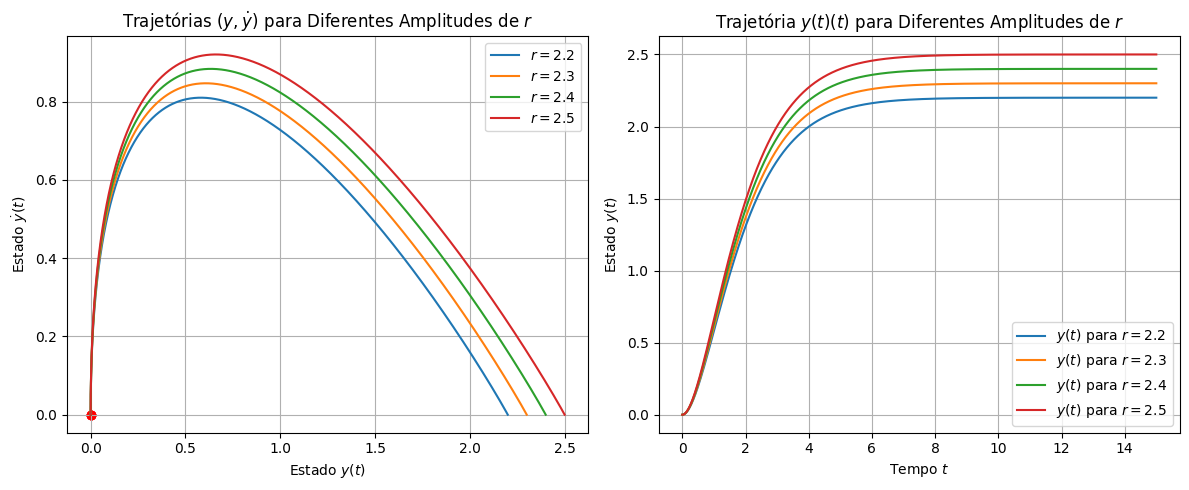

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de simulação
tempo_final = 15   # Tempo de simulação em segundos
passo = 0.001       # Passo de tempo fixo para o método de Euler
condicao_inicial = [0, 0]  # Condição inicial
amplitudes_r = [2.2, 2.3, 2.4, 2.5]  # Diferentes valores de referência r para simular

# Ganhos de realimentação para linearização
a0 = -3  # Ganho de realimentação para x1
a1 = 2   # Ganho de realimentação para x2

# Definição do sistema de equações diferenciais com realimentação
def sistema(y, a0, a1, r):
    x1, x2 = y
    # Controle por realimentação linearizante
    w = r + (0.5 - x1**2) * x2 - a1 * x2 - a0 * x1
    dx1_dt = x2
    dx2_dt = w - (0.5 - x1**2) * x2 - 4 * x1
    return np.array([dx1_dt, dx2_dt])

# Método de Euler para integração com passo fixo
def solver(sistema, y0, t_final, h, a0, a1, r):
    t = np.arange(0, t_final, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i-1] + h * sistema(y[i-1], a0, a1, r)
    return t, y

# Preparando o primeiro gráfico no espaço de estados (x1, x2)
plt.figure(figsize=(12, 5))

for r in amplitudes_r:
    t, y = solver(sistema, condicao_inicial, tempo_final, passo, a0, a1, r)
    x1, x2 = y[:, 0], y[:, 1]

    # Subplot para o espaço de estados (x1, x2)
    plt.subplot(1, 2, 1)
    plt.plot(x1, x2, label=f"$r = {r}$")
    plt.scatter(condicao_inicial[0], condicao_inicial[1], color="red")

    # Subplot para as trajetórias x1(t) em função do tempo
    plt.subplot(1, 2, 2)
    plt.plot(t, x1, label=f"$y(t)$ para $r = {r}$")

plt.subplot(1, 2, 1)
plt.xlabel("Estado $y(t)$")
plt.ylabel("Estado $\\dot y(t)$")
plt.title("Trajetórias $(y, \\dot y)$ para Diferentes Amplitudes de $r$")
plt.legend(loc="upper right")
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title("Trajetória $y(t)(t)$ para Diferentes Amplitudes de $r$")
plt.legend(loc="lower right")
plt.grid()

# Exibindo os gráficos
plt.tight_layout()
plt.show()

# a) Projeto de controle

O controlador escolhido será um controlador PI definido por:

$$
C(s) = \frac{K}{s}
$$

Usa-se o controlador apresentado para anular o erro em regime permanente e determinar o lugar das raízes desejadas pelo método de root locus.

In [2]:
!pip install control

   ---------------------------------------- 0.0/549.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.6 kB ? eta -:--:--
    --------------------------------------- 10.2/549.6 kB ? eta -:--:--
   ---- ---------------------------------- 61.4/549.6 kB 812.7 kB/s eta 0:00:01
   ---------------------------------------- 549.6/549.6 kB 4.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Text(0.5, 0.98, '')

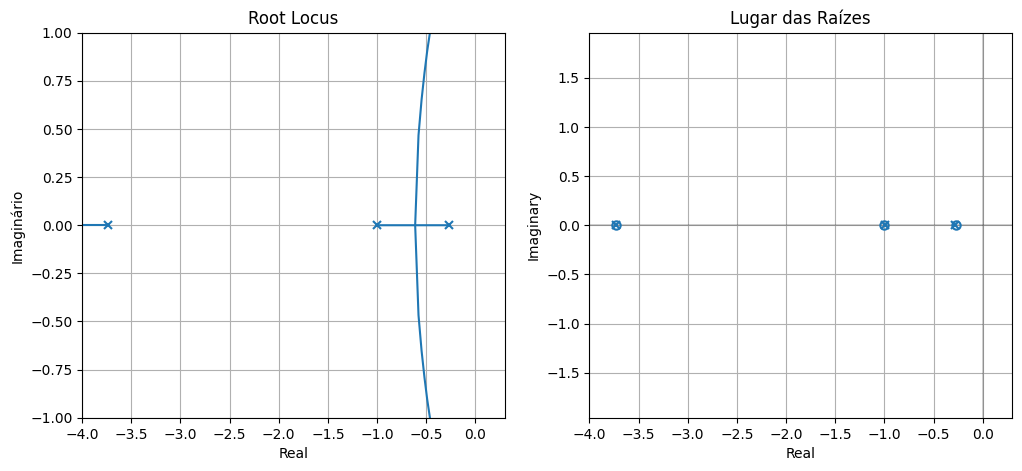

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

# Definir os ganhos do controlador PI
K = 0.15
Kp = K  # Ganho proporcional
Ki = K * a  # Ganho

# Definir o controlador PI
numerator_C = [K]  # Numerador : Kp * s + Ki
denominator_C = [1, 1]  # Denominador : s

# Definir a planta ideal
numerator_G = [1]  # Numerador de G(s) = 1
denominator_G = [1, 4, 1]

# Criar as funções de transferência para o controlador PI e para a planta
C = ctrl.TransferFunction(numerator_C, denominator_C)
G = ctrl.TransferFunction(numerator_G, denominator_G)

# Função de transferência em malha aberta com o controlador PI
CG = C * G

# Diagrama de Root Locus
fig = plt.figure(figsize=(12, 5))

# Configurações do gráfico
plt.subplot(1, 2, 1)
ctrl.root_locus(CG)
plt.title("Root Locus")
plt.xlabel("Real")
plt.ylabel("Imaginário")
plt.grid()
plt.xlim(-4,0.3)
plt.ylim(-1,1)


# Destaque dos polos e zeros em malha fechada
plt.subplot(1, 2, 2)
plt.title("Lugar das Raízes")
plt.xlabel("Real")
plt.ylabel("Imaginário")
ctrl.pzmap(1 / (1 + K * CG))
plt.grid()
plt.xlim(-4,0.3)
plt.ylim(-1,1)

fig.suptitle('')


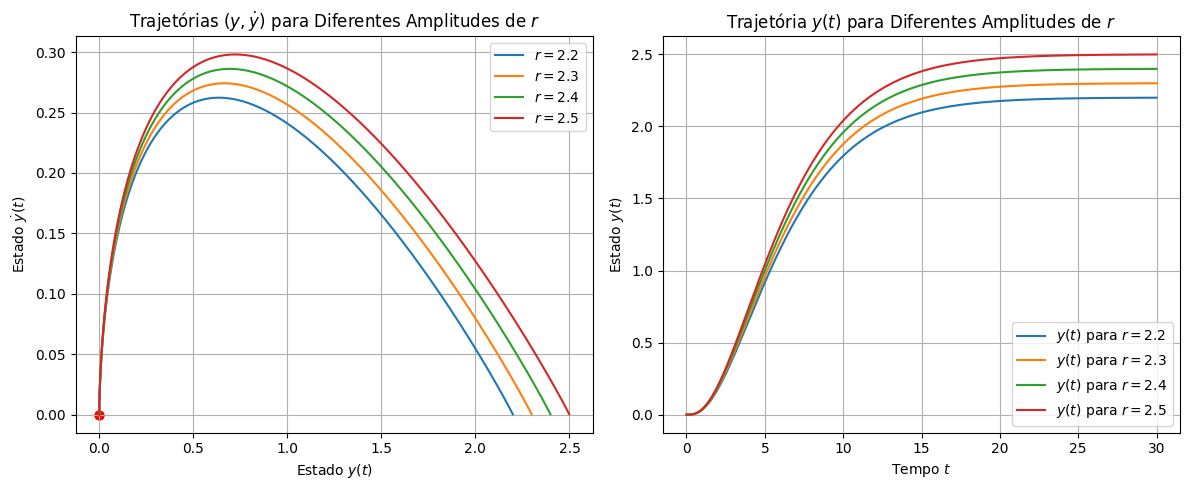

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de simulação
tempo_final = 30   # Tempo de simulação em segundos
passo = 0.001       # Passo de tempo fixo para o método de Euler
condicao_inicial = [0, 0, 0]  # Condição inicial
amplitudes_r = [2.2, 2.3, 2.4, 2.5]  # Diferentes valores de referência r para simular

# Ganhos do controlador I
K = 0.15

# Ganhos de realimentação para linearização
a0 = -3  # Ganho de realimentação para x1
a1 = 2   # Ganho de realimentação para x2

# Definição do sistema de equações diferenciais com realimentação
def sistema(y, a0, a1, r):
    x1, x2, e_int = y
    # Controle por realimentação linearizante
    e = r - x1
    w = K * e_int
    v = w + (0.5 - x1**2) * x2 - a1 * x2 - a0 * x1
    dx1_dt = x2
    dx2_dt = v - (0.5 - x1**2) * x2 - 4 * x1
    de_ind_dt = e
    return np.array([dx1_dt, dx2_dt, de_ind_dt])

# Método de Euler para integração com passo fixo
def solver(sistema, y0, t_final, h, a0, a1, r):
    t = np.arange(0, t_final, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i-1] + h * sistema(y[i-1], a0, a1, r)
    return t, y

# Preparando o primeiro gráfico no espaço de estados (x1, x2)
plt.figure(figsize=(12, 5))

for r in amplitudes_r:
    t, y = solver(sistema, condicao_inicial, tempo_final, passo, a0, a1, r)
    x1, x2 = y[:, 0], y[:, 1]

    # Subplot para o espaço de estados (x1, x2)
    plt.subplot(1, 2, 1)
    plt.plot(x1, x2, label=f"$r = {r}$")
    plt.scatter(condicao_inicial[0], condicao_inicial[1], color="red")

    # Subplot para as trajetórias x1(t) em função do tempo
    plt.subplot(1, 2, 2)
    plt.plot(t, x1, label=f"$y(t)$ para $r = {r}$")

plt.subplot(1, 2, 1)
plt.xlabel("Estado $y(t)$")
plt.ylabel("Estado $\\dot y(t)$")
plt.title("Trajetórias $(y, \\dot y)$ para Diferentes Amplitudes de $r$")
plt.legend(loc="upper right")
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title("Trajetória $y(t)$ para Diferentes Amplitudes de $r$")
plt.legend(loc="lower right")
plt.grid()

# Exibindo os gráficos
plt.tight_layout()
plt.show()

## b) Parte NL desconhecida

Nesta seção simulamos o controlador projetado para o sistema NL conhecido, na situação que a não linearidade seja menos e mais prominente. A seguir as simulações para cada caso.


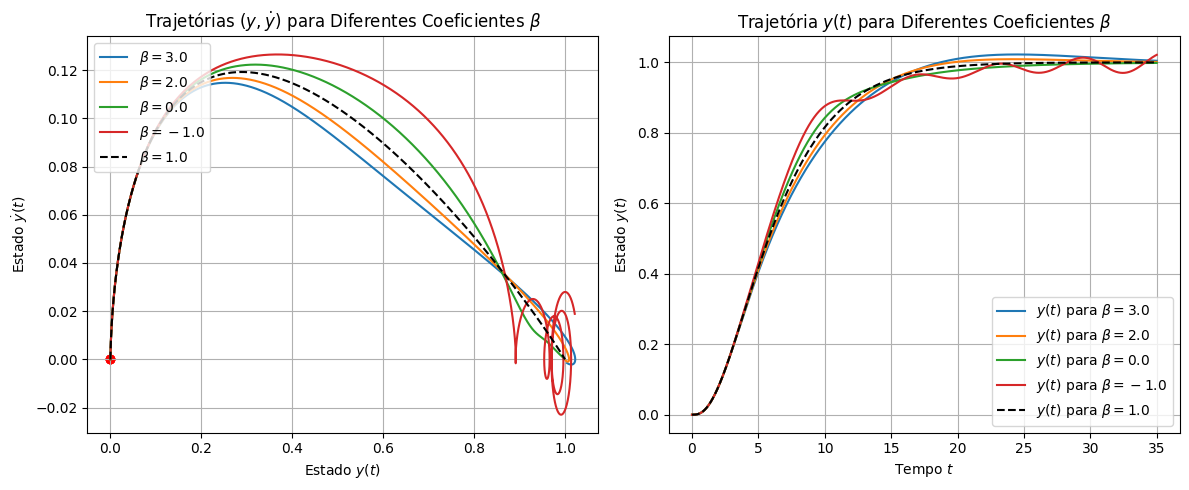

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros de simulação
tempo_final = 35
passo = 0.001
condicao_inicial = [0, 0, 0]  # Condição inicial
betas = [3.0, 2.0, 0.0, -1.0]  # Diferentes coeficientes beta para simular

# Ganhos do controlador PI
K = 0.15
a = 1

# Ganhos de realimentação para linearização
a0 = -3  # Ganho de realimentação para x1
a1 = 2   # Ganho de realimentação para x2

# Definição do sistema de equações diferenciais com realimentação
def sistema(y, a0, a1, beta):
    x1, x2, e_int = y
    # Controle por realimentação linearizante
    r = 1
    e = r - x1
    w = K * e_int
    v = w + (0.5 - beta * x1**2) * x2 - a1 * x2 - a0 * x1
    dx1_dt = x2
    dx2_dt = v - (0.5 - x1**2) * x2 - 4 * x1
    de_ind_dt = e
    return np.array([dx1_dt, dx2_dt, de_ind_dt])

# Método de Euler para integração com passo fixo
def solver(sistema, y0, t_final, h, a0, a1, beta):
    t = np.arange(0, t_final, h)
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i-1] + h * sistema(y[i-1], a0, a1, beta)
    return t, y

# Preparando o primeiro gráfico no espaço de estados (x1, x2)
plt.figure(figsize=(12, 5))

for beta in betas:
    t, y = solver(sistema, condicao_inicial, tempo_final, passo, a0, a1, beta)
    x1, x2 = y[:, 0], y[:, 1]

    # Subplot para o espaço de estados (x1, x2)
    plt.subplot(1, 2, 1)
    plt.plot(x1, x2, label=f"$\\beta = {beta}$")
    plt.scatter(condicao_inicial[0], condicao_inicial[1], color="red")

    # Subplot para as trajetórias x1(t) em função do tempo
    plt.subplot(1, 2, 2)
    plt.plot(t, x1, label=f"$y(t)$ para $\\beta = {beta}$")

# Beta = 1
t, y = solver(sistema, condicao_inicial, tempo_final, passo, a0, a1, 1)
x1, x2 = y[:, 0], y[:, 1]

plt.subplot(1, 2, 1)
plt.plot(x1, x2, label=f"$\\beta = {1.0}$", color='black', linestyle='--')

plt.xlabel("Estado $y(t)$")
plt.ylabel("Estado $\\dot y(t)$")
plt.title(f"Trajetórias $(y, \\dot y)$ para Diferentes Coeficientes $\\beta$")
plt.legend(loc="upper left")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(t, x1, label=f"$y(t)$ para $\\beta = {1.0}$", color='black', linestyle='--')

plt.xlabel("Tempo $t$")
plt.ylabel("Estado $y(t)$")
plt.title(f"Trajetória $y(t)$ para Diferentes Coeficientes $\\beta$")
plt.legend(loc="lower right")
plt.grid()

# Exibindo os gráficos
plt.tight_layout()
plt.show()